# PySpark Decision Tree Implementation

## Create Spark objects

In [4]:
from toolbox.createSpark import * # custom python module to find and create spark objects for us.
spark, sqlContext = createSpark() 

## Reading in the data

In [5]:
data = sqlContext.read.format("com.databricks.spark.csv")\
.option("header", "true")\
.option("inferschema", "true")\
.option("mode", "DROPMALFORMED")\
.load("data/Social_Network_Ads.csv")

In [9]:
import pyspark.sql.functions as F

# converting integer values in Purchased column to string, so that we can train the stringIndexer.
data =data.withColumn("Purchased", F.col("Purchased").cast('boolean').cast('string'))# 1 -> true -> 'true'


## Splitting the Data

In [14]:
(trainingData, testData) = data.randomSplit([0.8, 0.2])

## Creating the classification model

### Creating the stages for the pipeline model

In [15]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.classification import DecisionTreeClassifier

stages =[]

# stage to index output labels
stages.append(StringIndexer(inputCol='Purchased', outputCol='s_purchased',handleInvalid='skip').fit(trainingData))

# stage to index Gender
stages.append(StringIndexer(inputCol='Gender', outputCol='s_gender'))

# stage to encode gender to dummy variables
stages.append(OneHotEncoderEstimator(inputCols=['s_gender'], outputCols=['oh_s_gender']))

# stage for assempling features
stages.append(VectorAssembler(inputCols=['oh_s_gender','Age','EstimatedSalary'], outputCol='features'))

# stage for Decision Tree Classifier
stages.append(DecisionTreeClassifier(labelCol='s_purchased', featuresCol='features'))

# stage to re-index predictions to labels
stages.append(IndexToString(inputCol='prediction', outputCol='lab_prediction', labels = stages[0].labels))

### Creating the Pipeline model

In [16]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
model = pipeline.fit(trainingData)

## Making predictions and Evaluating the model

In [49]:
predictions = model.transform(testData)

# model evaluation for accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol='s_purchased', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Accuracy on testData  = %g and Test Error = %g"%(accuracy, 1-accuracy))


Accuracy on testData  = 0.922222 and Test Error = 0.0777778


## Visualising the Predictions

The plot is only using Age and Estimated Salary for 2d plotting of the predictions points.

In [35]:
import pandas as pd
import numpy as np
from plotnine import *
from plotnine.data import *
%matplotlib inline

df = predictions.select('s_gender','Age','EstimatedSalary','Purchased','lab_prediction').toPandas()
p = ggplot(df, aes(x='EstimatedSalary', y='Age', color = 'factor(lab_prediction)'))

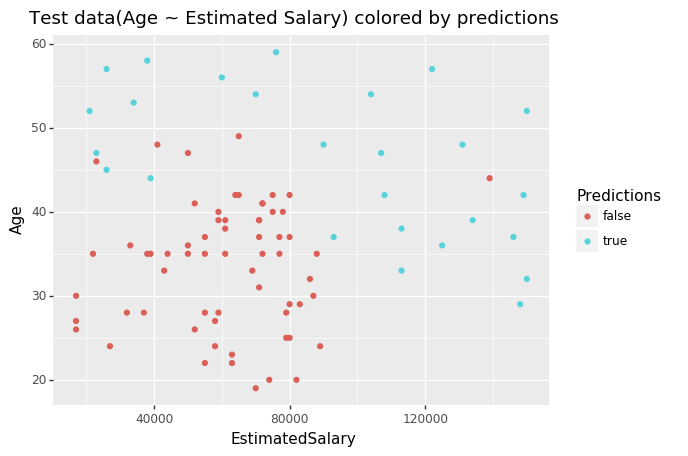

<ggplot: (-9223372036825891061)>

In [48]:
p+geom_point() + labs(title ="Test data(Age ~ Estimated Salary) colored by predictions",color = "Predictions")

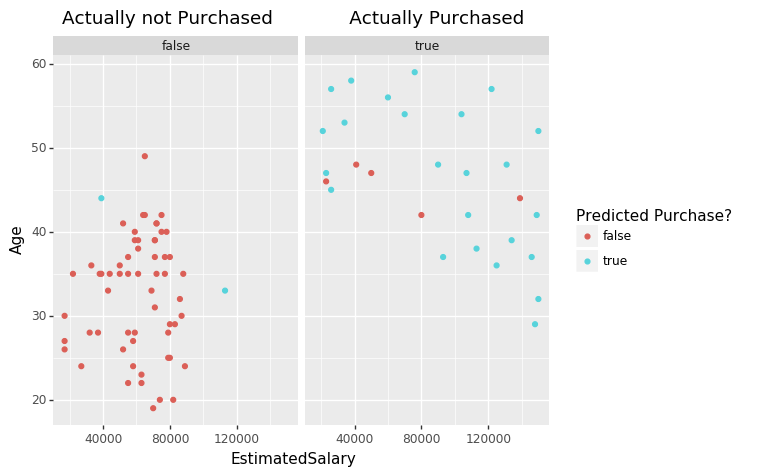

<ggplot: (-9223372036825933764)>

In [40]:
p+geom_point() + labs(title = "Actually not Purchased             Actually Purchased", color = "Predicted Purchase?") + facet_wrap("Purchased")

### Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df['Purchased'].values,df['lab_prediction'])
cm

array([[59,  2],
       [ 5, 24]], dtype=int64)

## Decision Tree Logic

In [25]:
print(model.stages[-2].toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_349a4cd28e61) of depth 5 with 29 nodes
  If (feature 1 <= 42.5)
   If (feature 2 <= 90500.0)
    If (feature 1 <= 36.5)
     Predict: 0.0
    Else (feature 1 > 36.5)
     If (feature 2 <= 80500.0)
      Predict: 0.0
     Else (feature 2 > 80500.0)
      Predict: 1.0
   Else (feature 2 > 90500.0)
    If (feature 1 <= 26.5)
     Predict: 0.0
    Else (feature 1 > 26.5)
     Predict: 1.0
  Else (feature 1 > 42.5)
   If (feature 1 <= 46.5)
    If (feature 2 <= 45500.0)
     If (feature 2 <= 25500.0)
      If (feature 1 <= 45.5)
       Predict: 1.0
      Else (feature 1 > 45.5)
       Predict: 0.0
     Else (feature 2 > 25500.0)
      Predict: 1.0
    Else (feature 2 > 45500.0)
     If (feature 2 <= 82500.0)
      Predict: 0.0
     Else (feature 2 > 82500.0)
      If (feature 0 in {1.0})
       Predict: 0.0
      Else (feature 0 not in {1.0})
       Predict: 1.0
   Else (feature 1 > 46.5)
    If (feature 2 <= 38500.0)
     Predict: